<a href="https://colab.research.google.com/github/HopeRetina/Lending-Club-default-prediction/blob/main/Lending_Club_default_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In this project, I used supervised learning to predict whether a LC loan will default

##First setup google drive, import libraries.

---



In [ ]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 12
pd.options.display.float_format = '{:.3f}'.format

from tabulate import tabulate

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#link = 'https://drive.google.com/file/d/1wpvbxGzzX1m0lcsnUXOAPd_vAE08URbN'

link = 'https://drive.google.com/open?id=1VOAhrB5eIhFc8C5qeFx5QYa2OLD7s1eV'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) 
file.GetContentFile('loan-clean-version.csv') 
lc_df  = pd.read_csv('loan-clean-version.csv')
lc_df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,...,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,loan_status
0,1077501,5000,5000,4975.000,36 months,10.650,162.870,B,10+ years,RENT,...,13648,83.700,9,0,0,5861.071,5831.780,5000.000,861.070,Fully Paid
1,1077430,2500,2500,2500.000,60 months,15.270,59.830,C,Less than 1 year,RENT,...,1687,9.400,4,0,0,1008.710,1008.710,456.460,435.170,Charged Off
2,1077175,2400,2400,2400.000,36 months,15.960,84.330,C,10+ years,RENT,...,2956,98.500,10,0,0,3003.654,3003.650,2400.000,603.650,Fully Paid
3,1076863,10000,10000,10000.000,36 months,13.490,339.310,C,10+ years,RENT,...,5598,21.000,37,0,0,12226.302,12226.300,10000.000,2209.330,Fully Paid
4,1075269,5000,5000,5000.000,36 months,7.900,156.460,A,3 years,RENT,...,7963,28.300,12,0,0,5631.378,5631.380,5000.000,631.380,Fully Paid


In [ ]:
lc_df.shape

(9004, 29)

In [ ]:
lc_df.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'purpose', 'addr_state', 'dti',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'loan_status'],
      dtype='object')

##Data exploration

---



In [ ]:
lc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9004 entries, 0 to 9003
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   9004 non-null   int64  
 1   loan_amnt            9004 non-null   int64  
 2   funded_amnt          9004 non-null   int64  
 3   funded_amnt_inv      9004 non-null   float64
 4   term                 9004 non-null   object 
 5   int_rate             9004 non-null   float64
 6   installment          9004 non-null   float64
 7   grade                9004 non-null   object 
 8   emp_length           8688 non-null   object 
 9   home_ownership       9004 non-null   object 
 10  annual_inc           9004 non-null   float64
 11  verification_status  9004 non-null   object 
 12  purpose              9004 non-null   object 
 13  addr_state           9004 non-null   object 
 14  dti                  9004 non-null   float64
 15  earliest_cr_line     9004 non-null   i

In [ ]:
# Check unique values
lc_df.nunique()

id                 9004
loan_amnt           604
funded_amnt         681
funded_amnt_inv    1234
term                  2
                   ... 
total_pymnt        8962
total_pymnt_inv    8942
total_rec_prncp    2199
total_rec_int      8838
loan_status           2
Length: 29, dtype: int64

In [ ]:
# Check missing values
lc_df.isnull().sum()

id                 0
loan_amnt          0
funded_amnt        0
funded_amnt_inv    0
term               0
                  ..
total_pymnt        0
total_pymnt_inv    0
total_rec_prncp    0
total_rec_int      0
loan_status        0
Length: 29, dtype: int64

In [ ]:
# Check the distribution of the target/label- loan_status
lc_df.loc[:, 'loan_status'].value_counts()

Fully Paid     7487
Charged Off    1517
Name: loan_status, dtype: int64

##EDA

---



In [ ]:
# Make a correlation heat map of numerical features
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

numericalCol = []
for col in lc_df:
  if lc_df[col].dtype == np.float:
    numericalCol.append(col)
corr = lc_df[numericalCol].corr()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


[Text(0.5, 0, 'funded_amnt_inv'),
 Text(1.5, 0, 'int_rate'),
 Text(2.5, 0, 'installment'),
 Text(3.5, 0, 'annual_inc'),
 Text(4.5, 0, 'dti'),
 Text(5.5, 0, 'revol_util'),
 Text(6.5, 0, 'total_pymnt'),
 Text(7.5, 0, 'total_pymnt_inv'),
 Text(8.5, 0, 'total_rec_prncp'),
 Text(9.5, 0, 'total_rec_int')]

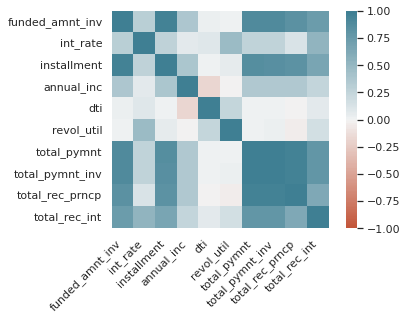

In [ ]:
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

###Make a prettier, interactive plot using Altair.

---



In [ ]:
# check the actual values of correlations
corr_score = lc_df[numericalCol].corr()
corr_score

,funded_amnt_inv,int_rate,installment,annual_inc,dti,revol_util,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int
funded_amnt_inv,1.000,0.303,0.959,0.372,0.025,0.022,0.884,0.885,0.829,0.734
int_rate,0.303,1.000,0.268,0.076,0.092,0.471,0.259,0.258,0.124,0.532
installment,0.959,0.268,1.000,0.385,0.017,0.056,0.860,0.859,0.828,0.660
annual_inc,0.372,0.076,0.385,1.000,-0.177,-0.005,0.366,0.365,0.366,0.253
dti,0.025,0.092,0.017,-0.177,1.000,0.243,0.020,0.020,-0.005,0.077
revol_util,0.022,0.471,0.056,-0.005,0.243,1.000,0.022,0.024,-0.037,0.171
total_pymnt,0.884,0.259,0.860,0.366,0.020,0.022,1.000,0.998,0.969,0.795
total_pymnt_inv,0.885,0.258,0.859,0.365,0.020,0.024,0.998,1.000,0.967,0.794
total_rec_prncp,0.829,0.124,0.828,0.366,-0.005,-0.037,0.969,0.967,1.000,0.634
total_rec_int,0.734,0.532,0.660,0.253,0.077,0.171,0.795,0.794,0.634,1.000


Some corresponding features (like total_pymnt and total_pymnt_inv) have high correlation.

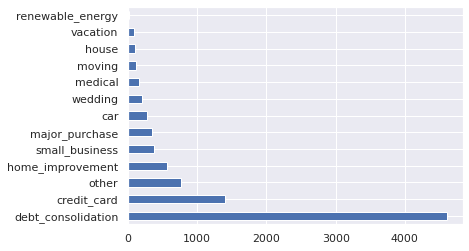

In [ ]:
# Explore the purpose category
lc_df["purpose"].value_counts().plot(kind='barh')

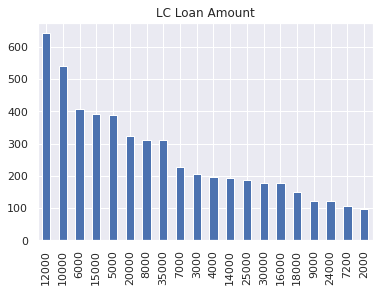

In [ ]:
# Further exploration
lc_df["loan_amnt"].value_counts()[:20].plot(kind='bar', title="LC Loan Amount")

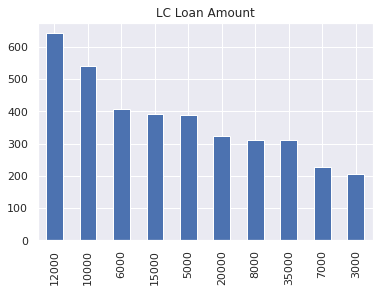

In [ ]:
lc_df["loan_amnt"].value_counts()[:10].plot(kind='bar', title="LC Loan Amount")
plt.show()

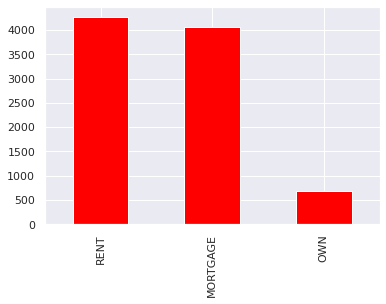

In [ ]:
# explore purpose category
lc_df["home_ownership"].value_counts().plot(kind='bar', color='red')
plt.show()

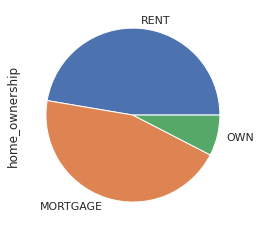

In [ ]:
lc_df['home_ownership'].value_counts().plot(kind='pie')
plt.show()

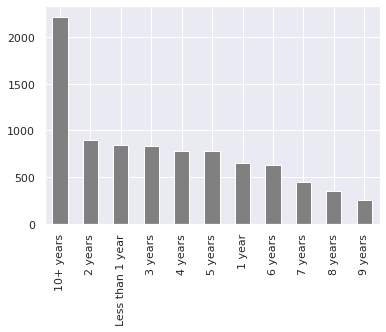

In [ ]:
lc_df['emp_length'].value_counts().plot(kind='bar', color='gray')
plt.show()

In [ ]:
# Total loan amount issued by state
df_state = lc_df.groupby("addr_state",).sum().reset_index()
df_state = df_state.filter(["addr_state", "loan_amnt"], axis = 1)

df_state.head()

,addr_state,loan_amnt
0,AK,359675
1,AL,1308425
2,AR,753275
3,AZ,2477200
4,CA,20470425


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=df_state['addr_state'], # Spatial coordinates
    z = df_state['loan_amnt'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "USD",
))

fig.update_layout(
    title_text = 'Total amount issued by State',
    geo_scope='usa', # limited map scope to USA
)

fig.show()

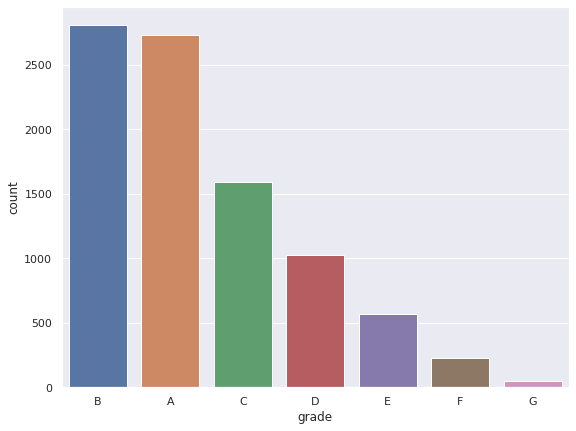

In [ ]:
# Grade distribution plot
plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
sns.countplot(x="grade", data= lc_df, order = lc_df['grade'].value_counts().index)


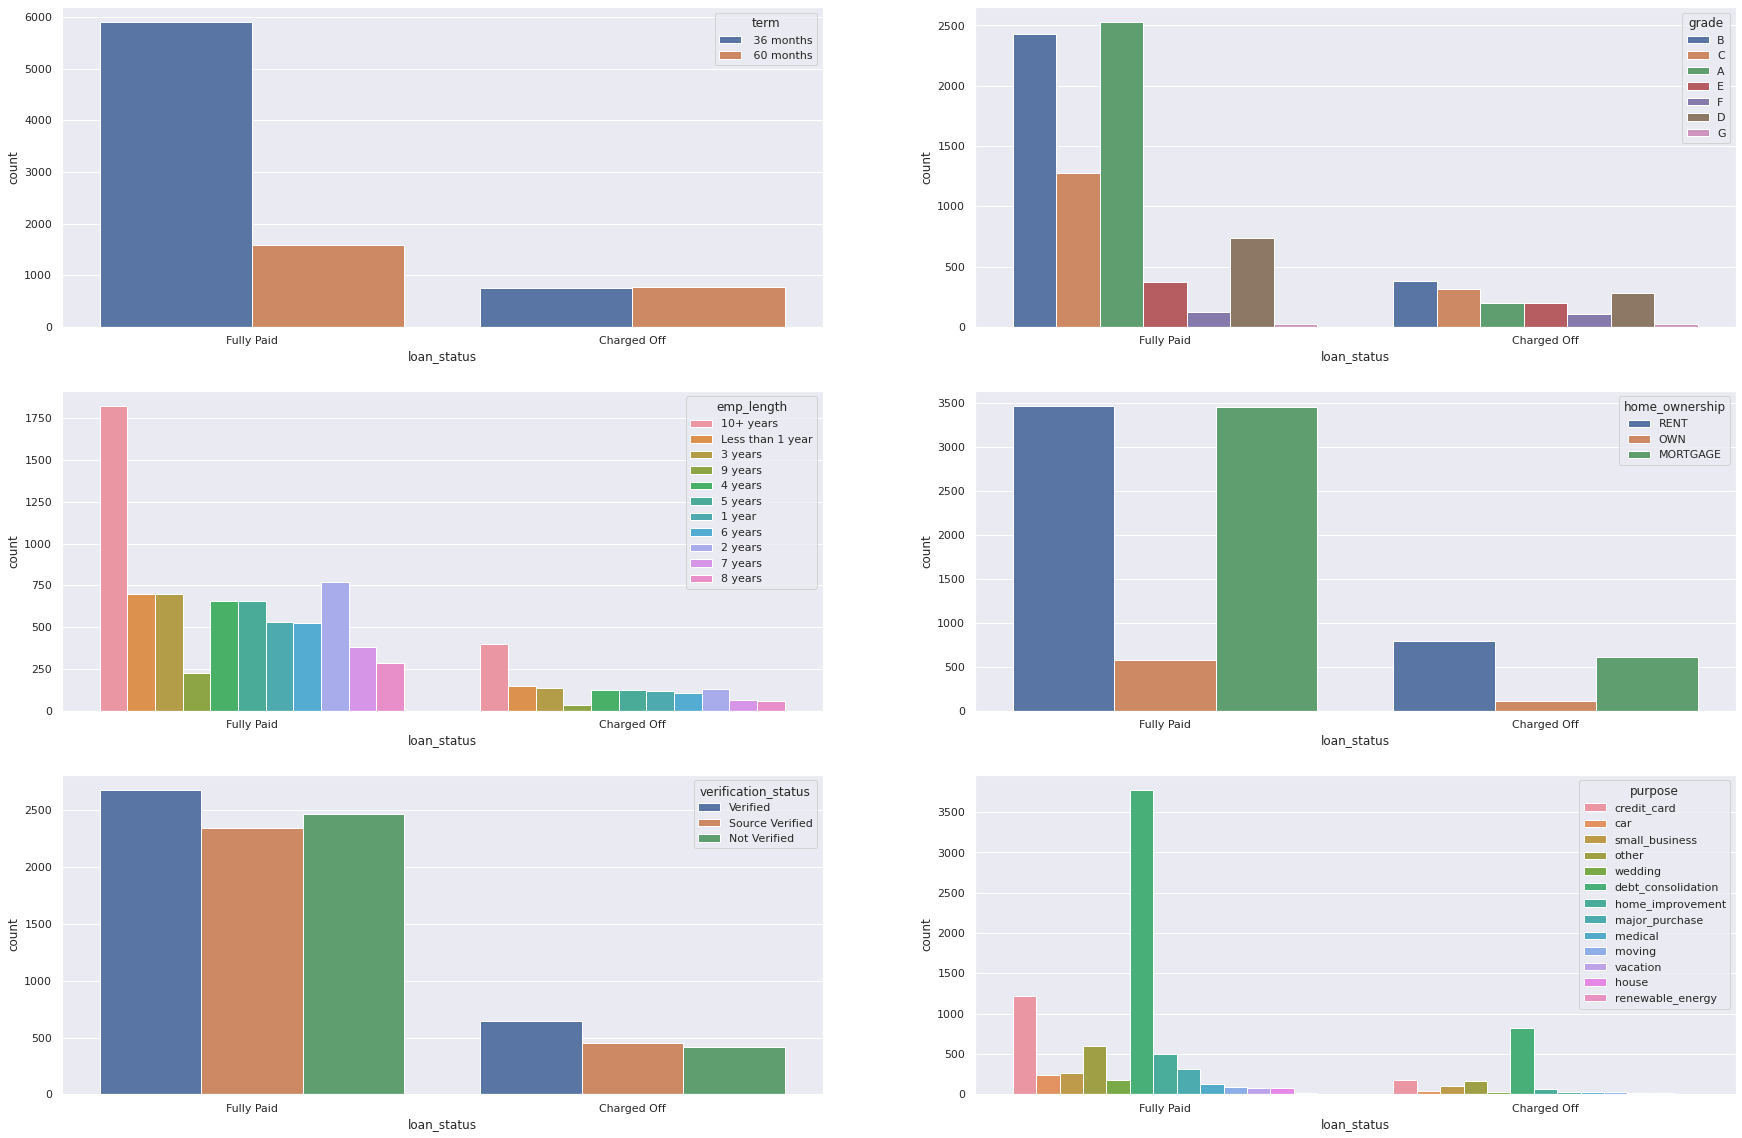

In [ ]:
# Now take a look at categorical features
_,axss = plt.subplots(3,2, figsize=[30,20])
sns.countplot(x='loan_status', hue='term', data=lc_df, ax=axss[0][0])
sns.countplot(x='loan_status', hue='grade', data=lc_df, ax=axss[0][1])
sns.countplot(x='loan_status', hue='emp_length', data=lc_df, ax=axss[1][0])
sns.countplot(x='loan_status', hue='home_ownership', data=lc_df, ax=axss[1][1])
sns.countplot(x='loan_status', hue='verification_status', data=lc_df, ax=axss[2][0])
sns.countplot(x='loan_status', hue='purpose', data=lc_df, ax=axss[2][1])

#Data cleaning and feature preprocessing

---



In [ ]:
lc_df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,...,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,loan_status
0,1077501,5000,5000,4975.000,36 months,10.650,162.870,B,10+ years,RENT,...,13648,83.700,9,0,0,5861.071,5831.780,5000.000,861.070,Fully Paid
1,1077430,2500,2500,2500.000,60 months,15.270,59.830,C,Less than 1 year,RENT,...,1687,9.400,4,0,0,1008.710,1008.710,456.460,435.170,Charged Off
2,1077175,2400,2400,2400.000,36 months,15.960,84.330,C,10+ years,RENT,...,2956,98.500,10,0,0,3003.654,3003.650,2400.000,603.650,Fully Paid
3,1076863,10000,10000,10000.000,36 months,13.490,339.310,C,10+ years,RENT,...,5598,21.000,37,0,0,12226.302,12226.300,10000.000,2209.330,Fully Paid
4,1075269,5000,5000,5000.000,36 months,7.900,156.460,A,3 years,RENT,...,7963,28.300,12,0,0,5631.378,5631.380,5000.000,631.380,Fully Paid


In [ ]:
lc_df.describe(include='all')

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,...,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,loan_status
count,9004.000,9004.000,9004.000,9004.000,9004,9004.000,9004.000,9004,8688,9004,...,9004.000,9001.000,9004.000,9004.000,9004.000,9004.000,9004.000,9004.000,9004.000,9004
unique,NaN,NaN,NaN,NaN,2,NaN,NaN,7,11,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,36 months,NaN,NaN,B,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
freq,NaN,NaN,NaN,NaN,6649,NaN,NaN,2809,2222,4262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7487
mean,963233.714,12291.884,12154.156,12076.055,NaN,12.127,357.478,NaN,NaN,NaN,...,13658.416,52.369,22.439,0.000,0.000,13037.548,12943.841,10563.493,2328.717,NaN
std,79532.382,8285.682,8096.937,8033.211,NaN,4.196,227.180,NaN,NaN,NaN,...,15038.825,27.645,11.147,0.000,0.000,9838.298,9743.910,7946.457,2650.982,NaN
min,458165.000,1000.000,1000.000,750.000,NaN,5.420,30.160,NaN,NaN,NaN,...,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN
25%,877884.000,6000.000,6000.000,6000.000,NaN,8.490,187.750,NaN,NaN,NaN,...,4559.750,30.500,14.000,0.000,0.000,5802.197,5779.940,4800.000,682.043,NaN
50%,987968.500,10000.000,10000.000,10000.000,NaN,11.710,312.910,NaN,NaN,NaN,...,9889.000,54.700,21.000,0.000,0.000,10623.210,10577.545,8650.000,1367.130,NaN
75%,1033606.750,16000.000,16000.000,15975.000,NaN,15.230,469.360,NaN,NaN,NaN,...,17468.250,75.000,29.000,0.000,0.000,17354.405,17225.490,14500.000,2881.767,NaN


##Data cleaning

---



In [ ]:
# Data Cleaning / Integration
class_mapping = {label:idx for idx, label in enumerate(np.unique(lc_df['term']))}
lc_df['term']=lc_df['term'].map(class_mapping)
class_mapping = {label:idx for idx, label in enumerate(np.unique(lc_df['grade']))}
lc_df['grade']=lc_df['grade'].map(class_mapping)
class_mapping = {label:idx for idx, label in enumerate(np.unique(lc_df['home_ownership']))}
lc_df['home_ownership']=lc_df['home_ownership'].map(class_mapping)

class_mapping = {label:idx for idx, label in enumerate(np.unique(lc_df['verification_status']))}
lc_df['verification_status']=lc_df['verification_status'].map(class_mapping)

class_mapping = {label:idx for idx, label in enumerate(np.unique(lc_df['purpose']))}
lc_df['purpose']=lc_df['purpose'].map(class_mapping)

class_mapping = {label:idx for idx, label in enumerate(np.unique(lc_df['addr_state']))}
lc_df['addr_state']=lc_df['addr_state'].map(class_mapping)

class_mapping = {'Fully Paid' : 0, 'Charged Off' : 1}
lc_df['loan_status']=lc_df['loan_status'].map(class_mapping)

lc_df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,...,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,loan_status
0,1077501,5000,5000,4975.000,0,10.650,162.870,1,10+ years,2,...,13648,83.700,9,0,0,5861.071,5831.780,5000.000,861.070,0
1,1077430,2500,2500,2500.000,1,15.270,59.830,2,Less than 1 year,2,...,1687,9.400,4,0,0,1008.710,1008.710,456.460,435.170,1
2,1077175,2400,2400,2400.000,0,15.960,84.330,2,10+ years,2,...,2956,98.500,10,0,0,3003.654,3003.650,2400.000,603.650,0
3,1076863,10000,10000,10000.000,0,13.490,339.310,2,10+ years,2,...,5598,21.000,37,0,0,12226.302,12226.300,10000.000,2209.330,0
4,1075269,5000,5000,5000.000,0,7.900,156.460,0,3 years,2,...,7963,28.300,12,0,0,5631.378,5631.380,5000.000,631.380,0


In [ ]:
# Deal with missing values
lc_df = lc_df.select_dtypes(include=[np.number]).interpolate().dropna()
# drop high correlation and high variance colums
lc_df = lc_df.drop(["total_pymnt"], axis=1)
lc_df = lc_df.drop(["total_pymnt_inv"], axis=1)
lc_df = lc_df.drop(["total_rec_int"], axis=1)
lc_df = lc_df.drop(["id"], axis=1)
lc_df = lc_df.drop(["total_rec_prncp"], axis=1)

lc_df.head(10)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,loan_status
0,5000,5000,4975.000,0,10.650,162.870,1,2,24000.000,2,...,31048,1,3,0,13648,83.700,9,0,0,0
1,2500,2500,2500.000,1,15.270,59.830,2,2,30000.000,1,...,36251,5,3,0,1687,9.400,4,0,0,1
2,2400,2400,2400.000,0,15.960,84.330,2,2,12252.000,0,...,43040,2,2,0,2956,98.500,10,0,0,0
3,10000,10000,10000.000,0,13.490,339.310,2,2,49200.000,1,...,35096,1,10,0,5598,21.000,37,0,0,0
4,5000,5000,5000.000,0,7.900,156.460,0,2,36000.000,1,...,43043,3,9,0,7963,28.300,12,0,0,0
5,3000,3000,3000.000,0,18.640,109.430,4,2,48000.000,1,...,42742,2,4,0,8221,87.500,4,0,0,0
6,5600,5600,5600.000,1,21.280,152.390,5,1,40000.000,1,...,42829,2,11,0,5210,32.600,13,0,0,1
7,5375,5375,5350.000,1,12.690,121.450,1,2,15000.000,2,...,42982,0,2,0,9279,36.500,3,0,0,1
8,6500,6500,6500.000,1,14.650,153.450,2,1,72000.000,0,...,35796,2,14,0,4032,20.600,23,0,0,0
9,12000,12000,12000.000,0,12.690,402.540,1,1,75000.000,1,...,32782,0,12,0,23336,67.100,34,0,0,0


##Splitting data

In [ ]:
# split dataset
from sklearn.model_selection import train_test_split

yPredict = lc_df.loan_status
XClean = lc_df.drop(["loan_status"], axis=1)

# Reserve 25% for testing
X_train, X_test, y_train, y_test = train_test_split(XClean, yPredict, random_state=7, test_size=0.3)

In [ ]:
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv
5704,19075,19075,18775.000,0,7.900,596.870,0,0,82000.000,2,...,11.060,33939,1,6,0,15616,51.700,23,0,0
1265,12000,12000,12000.000,0,13.490,407.170,2,1,79768.000,1,...,16.730,36647,2,6,0,2093,36.700,21,0,0
5087,10000,10000,10000.000,0,10.650,325.740,1,2,108000.000,0,...,4.870,36161,0,4,0,6575,82.200,18,0,0
1678,7000,7000,7000.000,0,12.690,234.820,1,2,48000.000,2,...,21.950,35278,0,21,0,13100,69.300,26,0,0
2948,4000,4000,4000.000,0,9.910,128.900,1,0,60000.000,2,...,22.240,36800,0,8,0,2076,64.900,13,0,0


In [ ]:
y_train.head()

5704    0
1265    0
5087    0
1678    0
2948    0
Name: loan_status, dtype: int64

##Data preprocessing

---



In [ ]:
# Transform file
# Standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Part3: Modeling

## 3.1: RandomForest/ KNN/ LogisticRegression

---



###Build models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

In [ ]:
classifier_logistic.fit(X_train, y_train)

LogisticRegression()

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
prediction_Regression = classifier_logistic.predict(X_test)
print(classification_report(y_test,prediction_Regression))

              precision    recall  f1-score   support

           0       0.84      0.98      0.91      2245
           1       0.47      0.08      0.13       457

    accuracy                           0.83      2702
   macro avg       0.66      0.53      0.52      2702
weighted avg       0.78      0.83      0.77      2702



In [ ]:
classifier_KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
prediction_KNN = classifier_KNN.predict(X_test)
print(classification_report(y_test,prediction_KNN))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      2245
           1       0.44      0.15      0.22       457

    accuracy                           0.82      2702
   macro avg       0.64      0.56      0.56      2702
weighted avg       0.78      0.82      0.79      2702



In [ ]:
classifier_RF.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
prediction_RF = classifier_RF.predict(X_test)
print(classification_report(y_test,prediction_RF))

              precision    recall  f1-score   support

           0       0.84      0.98      0.91      2245
           1       0.46      0.07      0.12       457

    accuracy                           0.83      2702
   macro avg       0.65      0.53      0.51      2702
weighted avg       0.77      0.83      0.77      2702



###Cross validation

In [ ]:
# Use 5-fold Cross Validation to get the accuracy for different models
from sklearn import model_selection

model_names = ['Logistic Regression','KNN','Random Forest']
model_list = [classifier_logistic, classifier_KNN, classifier_RF]
count = 0

for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv=7)
    print(cv_score)
    print('Model accuracy of ' + model_names[count] + ' is ' + str(cv_score.mean()))
    count += 1

[0.83795782 0.84017758 0.83222222 0.84222222 0.82777778 0.84
 0.84      ]
Model accuracy of Logistic Regression is 0.8371939467610944
[0.81354051 0.82019978 0.81111111 0.82777778 0.80888889 0.81666667
 0.81222222]
Model accuracy of KNN is 0.8157724221764177
[0.82574917 0.83018868 0.83444444 0.82555556 0.82777778 0.81666667
 0.83555556]
Model accuracy of Random Forest is 0.8279911209766925


Logistic regression has the best performance among the three

##Other models: SVM

In [ ]:
from sklearn.svm import SVC 

classifier_SVC = SVC()

cv_score = model_selection.cross_val_score(classifier_SVC, X_train, y_train, cv=7)
print('Model accuracy of SVM is: ' + str(cv_score.mean()))

Model accuracy of SVM is: 0.832434156052358


##Other models: neural network

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(40,40,40), max_iter=1000, solver='sgd')
mlp.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



MLPClassifier(hidden_layer_sizes=(40, 40, 40), max_iter=1000, solver='sgd')

In [ ]:
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,predictions))

[[2122  123]
 [ 385   72]]


In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      0.95      0.89      2245
           1       0.37      0.16      0.22       457

    accuracy                           0.81      2702
   macro avg       0.61      0.55      0.56      2702
weighted avg       0.77      0.81      0.78      2702



#Part4: Feature Importance

In [ ]:
X_with_corr = XClean.copy()
X_with_corr.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv
0,5000,5000,4975.000,0,10.650,162.870,1,2,24000.000,2,...,27.650,31048,1,3,0,13648,83.700,9,0,0
1,2500,2500,2500.000,1,15.270,59.830,2,2,30000.000,1,...,1.000,36251,5,3,0,1687,9.400,4,0,0
2,2400,2400,2400.000,0,15.960,84.330,2,2,12252.000,0,...,8.720,43040,2,2,0,2956,98.500,10,0,0
3,10000,10000,10000.000,0,13.490,339.310,2,2,49200.000,1,...,20.000,35096,1,10,0,5598,21.000,37,0,0
4,5000,5000,5000.000,0,7.900,156.460,0,2,36000.000,1,...,11.200,43043,3,9,0,7963,28.300,12,0,0


In [ ]:
y=yPredict.copy()

In [ ]:
# check feature importance of random forest for feature selection
forest = RandomForestClassifier()
forest.fit(XClean, yPredict)

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for ind in range(XClean.shape[1]):
  print ("{0} : {1}".format(XClean.columns[indices[ind]],round(importances[indices[ind]], 4)))

Feature importance ranking by Random Forest Model:
annual_inc : 0.0809
revol_util : 0.0785
int_rate : 0.0773
earliest_cr_line : 0.0773
dti : 0.0745
revol_bal : 0.0723
installment : 0.0655
total_acc : 0.0607
addr_state : 0.0543
funded_amnt_inv : 0.0534
open_acc : 0.049
funded_amnt : 0.0463
loan_amnt : 0.0456
purpose : 0.0347
term : 0.0341
grade : 0.0307
inq_last_6mths : 0.0253
verification_status : 0.018
home_ownership : 0.0153
pub_rec : 0.0062
out_prncp : 0.0
out_prncp_inv : 0.0


In [ ]:
# add L1 regularization to logistic regression
# check the coef for feature selection
scaler = StandardScaler()
X_l1 = scaler.fit_transform(X_with_corr)
LRmodel_l1 = LogisticRegression(penalty="l1", C = 10, solver='liblinear')
LRmodel_l1.fit(X_l1, yPredict)

indices = np.argsort(abs(LRmodel_l1.coef_[0]))[::-1]

print ("Logistic Regression (L1) Coefficients")
for ind in range(X_with_corr.shape[1]):
  print ("{0} : {1}".format(X_with_corr.columns[indices[ind]],round(LRmodel_l1.coef_[0][indices[ind]], 4)))

Logistic Regression (L1) Coefficients
int_rate : 0.5643
annual_inc : -0.5007
term : 0.4156
funded_amnt : -0.3879
funded_amnt_inv : 0.2957
purpose : 0.2064
revol_util : 0.1436
loan_amnt : 0.1356
grade : -0.1148
inq_last_6mths : 0.0983
verification_status : -0.0807
home_ownership : 0.0751
earliest_cr_line : -0.0649
addr_state : -0.062
pub_rec : 0.0601
open_acc : 0.0585
total_acc : -0.0555
installment : 0.0506
dti : 0.0319
revol_bal : -0.0023
out_prncp : 0.0
out_prncp_inv : 0.0


##Now use SHAP to explain feature importance

" We estimate how important a model is by seeing how well the model performs with and without that feature for every combination of features."

"Shapley Additive Explanations calculates the local feature importance for every observation which is different from the method used in scikit-learn which computes the global feature importance. You can understand that the importance of a feature may not be uniform across all data points. So, local feature importance calculates the importance of each feature for each data point. "

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 5.2 MB/s 


In [ ]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [ ]:
# Collect shap values
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(XClean)


In [ ]:
type(explainer)

shap.explainers._tree.Tree

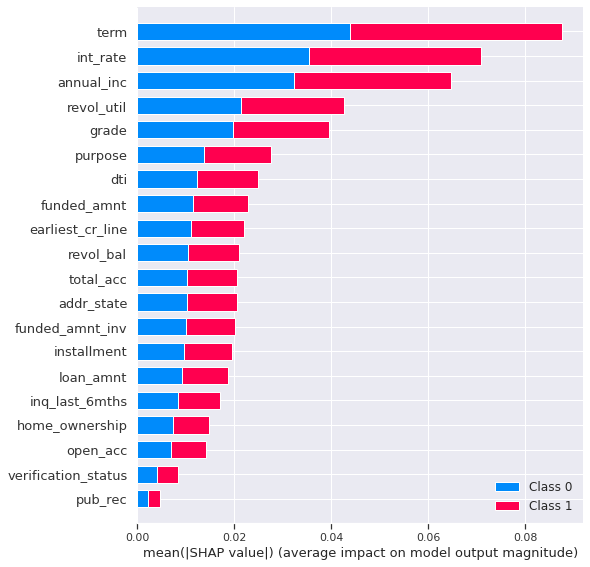

In [ ]:
# Make a bar plot
shap.summary_plot(shap_values, features=XClean, feature_names=XClean.columns, plot_type='bar')